In [61]:
import os
import warnings
from collections import Counter
from datetime import datetime
from functools import partial
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
from deep_translator import GoogleTranslator
from fastai.callback.progress import CSVLogger
from fastai.callback.tracker import EarlyStoppingCallback, SaveModelCallback
from fastai.learner import DataLoaders
from fastai.metrics import RocAuc
from fastai.optimizer import OptimWrapper
from fastai.vision.all import Learner
from sentence_transformers import SentenceTransformer, util
from sklearn.model_selection import train_test_split
from torch import nn
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from transformers import BertModel, BertTokenizer

In [3]:
warnings.filterwarnings("ignore", category=FutureWarning)

In [4]:
base_dir = os.getcwd()
track_a_dir = os.path.join(base_dir, "public_data", "train", "track_a")

# List all files in track_a that end with '.csv'
csv_files = [f for f in os.listdir(track_a_dir) if f.endswith('.csv')]

# Extract the language code from each file name (e.g., 'eng' from 'eng.csv')
languages = [os.path.splitext(filename)[0] for filename in csv_files]

print("Languages found in track_a folder:")
for lang in languages:
    print(lang)

Languages found in track_a folder:
afr
amh
deu
eng
oro
ptbr
rus
som
sun
tir


In [5]:
for filename in csv_files:
    language = os.path.splitext(filename)[0]  # e.g., 'eng' from 'eng.csv'
    file_path = os.path.join(track_a_dir, filename)
    
    df = pd.read_csv(file_path)
    
    remaining_columns = [col for col in df.columns if col not in ('id', 'text')]
    
    print(f"Language '{language}' has {len(remaining_columns)} emotion labels.")

Language 'afr' has 5 emotion labels.
Language 'amh' has 6 emotion labels.
Language 'deu' has 6 emotion labels.
Language 'eng' has 5 emotion labels.
Language 'oro' has 6 emotion labels.
Language 'ptbr' has 6 emotion labels.
Language 'rus' has 6 emotion labels.
Language 'som' has 6 emotion labels.
Language 'sun' has 6 emotion labels.
Language 'tir' has 6 emotion labels.


In [39]:
data = {}
for filename in csv_files:
    language = os.path.splitext(filename)[0]
    if language.lower() == 'afr':
        print(f"Skipping file {filename}.")
        continue
    file_path = os.path.join(track_a_dir, filename)
    
    df = pd.read_csv(file_path)
    
    # If the 'Disgust' column exists, remove rows where 'Disgust' equals 1
    disgust_cols = [col for col in df.columns if col.lower() == 'disgust']
    if disgust_cols:
        # Use the first found column (should be only one)
        col = disgust_cols[0]
        df = df[df[col] != 1]
        df = df.drop(columns=[col])
    
    # Dynamically assign the DataFrame to a variable named data_{language}
    data[language] = df
    
    print(f"Loaded {filename} into data['{language}'] with shape: {df.shape}")

# Example access: display first few rows of the English dataset if it exists
for key in data.keys():
    print(data[key].columns)

Skipping file afr.csv.
Loaded amh.csv into data['amh'] with shape: (2281, 7)
Loaded deu.csv into data['deu'] with shape: (1771, 7)
Loaded eng.csv into data['eng'] with shape: (2768, 7)
Loaded oro.csv into data['oro'] with shape: (2885, 7)
Loaded ptbr.csv into data['ptbr'] with shape: (2151, 7)
Loaded rus.csv into data['rus'] with shape: (2406, 7)
Loaded som.csv into data['som'] with shape: (2915, 7)
Loaded sun.csv into data['sun'] with shape: (856, 7)
Loaded tir.csv into data['tir'] with shape: (2370, 7)
Index(['id', 'text', 'Anger', 'Fear', 'Joy', 'Sadness', 'Surprise'], dtype='object')
Index(['id', 'text', 'Anger', 'Fear', 'Joy', 'Sadness', 'Surprise'], dtype='object')
Index(['id', 'text', 'Anger', 'Fear', 'Joy', 'Sadness', 'Surprise'], dtype='object')
Index(['id', 'text', 'Anger', 'Fear', 'Joy', 'Sadness', 'Surprise'], dtype='object')
Index(['id', 'text', 'Anger', 'Fear', 'Joy', 'Sadness', 'Surprise'], dtype='object')
Index(['id', 'text', 'Anger', 'Fear', 'Joy', 'Sadness', 'Surprise

In [40]:
labels = [col for col in next(iter(data.values())).columns if col not in ['id', 'text']]
print("Labels:", labels)

Labels: ['Anger', 'Fear', 'Joy', 'Sadness', 'Surprise']


In [41]:
def translate_text(text, source_lang, target_lang='en'):
    translated_text = GoogleTranslator(source=source_lang, target=target_lang).translate(text)
    return translated_text

def back_translate(text, source_lang='en', target_lang='de'):
    translated_text = GoogleTranslator(source=source_lang, target=target_lang).translate(text)
    back_translated_text = GoogleTranslator(source=target_lang, target=source_lang).translate(translated_text)
    return back_translated_text

lang_mapping = {
    'amh': 'am',    # Amharic
    'deu': 'de',    # German
    'eng': 'en',    # English
    'oro': 'om',    # Oromo
    'ptbr': 'pt',   # Brazilian Portuguese (or "pt-br" if needed)
    'rus': 'ru',    # Russian
    'som': 'so',    # Somali
    'sun': 'su',    # Sundanese
    'tir': 'ti',    # Tigrinya
}

In [42]:
# Initialize the sentence transformer model
model = SentenceTransformer('all-MiniLM-L6-v2')

In [43]:
SIM_THRESHOLD = 0.80
data_translated = {}

for lang, df in data.items():
    # if lang != "eng":
    #     df = df[:10]
    # else:
    #     df = df[:100]
    augmented_data = []
    
    if lang.lower() == 'eng':
        # For English, use back-translation
        for text in tqdm(df['text'], desc=f"Back-translating for {lang}", unit="sentence"):
            augmented_text = back_translate(text)
            augmented_data.append(augmented_text)
        
        original_df = df.copy()
        augmented_df = df.copy()
        augmented_df['text'] = augmented_data
        
        original_texts = original_df['text'].tolist()
        augmented_texts = augmented_df['text'].tolist()
        
        original_embeddings = model.encode(original_texts, convert_to_tensor=True)
        augmented_embeddings = model.encode(augmented_texts, convert_to_tensor=True)
        
        indices_to_keep = []
        for i, aug_emb in enumerate(augmented_embeddings):
            sims = util.cos_sim(aug_emb, original_embeddings)
            if sims.max().item() < SIM_THRESHOLD:
                indices_to_keep.append(i)
        
        filtered_augmented_df = augmented_df.iloc[indices_to_keep]
        
        df_aug = pd.concat([original_df, filtered_augmented_df], ignore_index=True)
        
    else:
        # For non-English datasets, use simple translation to English
        source_lang = lang.lower()
        if source_lang in lang_mapping:
            source_lang = lang_mapping[source_lang]
        for text in tqdm(df['text'], desc=f"Translating for {lang}", unit="sentence"):
            augmented_text = translate_text(text, source_lang=source_lang, target_lang='en')
            augmented_data.append(augmented_text)
        
        augmented_df = df.copy()
        augmented_df['text'] = augmented_data
        
        df_aug = augmented_df
    
    data_translated[lang] = df_aug
    
    if 'labels' in globals():
        distribution_after_augmentation = df_aug[labels].sum()
        print(f"Distribution after augmentation for {lang}:")
        print(distribution_after_augmentation)
    else:
        print(f"Completed augmentation for {lang}, resulting in {df_aug.shape[0]} rows.")

Translating for amh: 100%|██████████| 10/10 [00:01<00:00,  7.19sentence/s]


Distribution after augmentation for amh:
Anger       2
Fear        0
Joy         3
Sadness     2
Surprise    0
dtype: int64


Translating for deu: 100%|██████████| 10/10 [00:01<00:00,  7.22sentence/s]


Distribution after augmentation for deu:
Anger       3
Fear        1
Joy         3
Sadness     0
Surprise    1
dtype: int64


Back-translating for eng: 100%|██████████| 100/100 [00:52<00:00,  1.90sentence/s]


Distribution after augmentation for eng:
Anger       10
Fear        58
Joy         34
Sadness     35
Surprise    30
dtype: int64


Translating for oro: 100%|██████████| 10/10 [00:01<00:00,  6.83sentence/s]


Distribution after augmentation for oro:
Anger       0
Fear        1
Joy         4
Sadness     0
Surprise    1
dtype: int64


Translating for ptbr: 100%|██████████| 10/10 [00:01<00:00,  7.08sentence/s]


Distribution after augmentation for ptbr:
Anger       1
Fear        0
Joy         3
Sadness     2
Surprise    0
dtype: int64


Translating for rus: 100%|██████████| 10/10 [00:01<00:00,  6.78sentence/s]


Distribution after augmentation for rus:
Anger       3
Fear        2
Joy         2
Sadness     1
Surprise    1
dtype: int64


Translating for som: 100%|██████████| 10/10 [00:01<00:00,  7.40sentence/s]


Distribution after augmentation for som:
Anger       1
Fear        1
Joy         3
Sadness     3
Surprise    1
dtype: int64


Translating for sun: 100%|██████████| 10/10 [00:01<00:00,  5.21sentence/s]


Distribution after augmentation for sun:
Anger       0
Fear        0
Joy         8
Sadness     1
Surprise    2
dtype: int64


Translating for tir: 100%|██████████| 10/10 [00:01<00:00,  7.05sentence/s]

Distribution after augmentation for tir:
Anger       3
Fear        1
Joy         0
Sadness     2
Surprise    2
dtype: int64


In [44]:
df_translated = pd.concat(data_translated.values(), ignore_index=True)
df_translated.to_csv('df_translated.csv', index=False)
display(df_translated)

,id,text,Anger,Fear,Joy,Sadness,Surprise
0,amh_train_track_a_00001,God bless you ::: This is what it means to be a child: We are very happy with your happiness ::: Blessed are you,0,0,1,0,0
1,amh_train_track_a_00002,"Tefik, may your soul learn, you almost burned us, we were finally freed, I am very happy that you met with Momotu Azize and Cevdet, my dears.",0,0,1,0,0
2,amh_train_track_a_00003,"Many people will praise the generous man, and he is a friend to everyone who gives gifts. The poor man is hated by all his brothers, and even more so by his friends. If he follows them in word, he will not gain anything. [Proverbs 19:6-7]",0,0,0,0,0
3,amh_train_track_a_00004,"I think we should have a little bit of what we're talking about. This includes his fans. Suddenly, you woke up. His birthday was right. His birthday was like this. If my birthday is for you, I'll go with you.",1,0,0,0,0
4,amh_train_track_a_00007,The government cannot bring about any positive change in the ongoing war of mass destruction unless it completely destroys the Amhara region.,1,0,0,0,0
5,amh_train_track_a_00008,"In these 5 years, more people have been killed, displaced, and starved than during the Red Terror, not just the Badme War but the Derg War combined.",0,0,0,1,0
6,amh_train_track_a_00010,"I have no words, Kidane Mireth, ease your suffering, my sister, take heart, my poor girl, what kind of time have we reached, all this injustice against a little girl, what will mend this heartbreak for you 😭😭😭",0,0,0,1,0
7,amh_train_track_a_00011,Netanyahu rejects Hamas ceasefire conditions,0,0,0,0,0
8,amh_train_track_a_00012,African Cup winners receive cash and villa prizes,0,0,1,0,0
9,amh_train_track_a_00016,"Indeed, Hitler was farsighted, not cruel!!!",0,0,0,0,0


In [48]:
# Dataset definition
class EmotionDataset(Dataset):
    def __init__(self, data, tokenizer, max_len=128):
        self.texts = data["text"].tolist()
        self.labels = data[["Anger", "Fear", "Joy", "Sadness", "Surprise"]].values
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        labels = torch.tensor(self.labels[idx], dtype=torch.float)
        encodings = self.tokenizer(
            text,
            max_length=self.max_len,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )
        input_ids = encodings["input_ids"].squeeze(0)
        attention_mask = encodings["attention_mask"].squeeze(0)
        return (input_ids, attention_mask), labels

# TransMIL definition
class RMSNorm(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.scale = dim ** 0.5
        self.gamma = nn.Parameter(torch.ones(dim))

    def forward(self, x):
        return nn.functional.normalize(x, dim=-1) * self.scale * self.gamma

class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, norm_layer=nn.LayerNorm, dropout=0.):
        super().__init__()
        self.mlp = nn.Sequential(
            norm_layer(dim),
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        return self.mlp(x)

class Attention(nn.Module):
    def __init__(self, dim, heads=8, dim_head=512 // 8, norm_layer=nn.LayerNorm, dropout=0.):
        super().__init__()
        self.heads = heads
        self.norm = norm_layer(dim)
        self.mhsa = nn.MultiheadAttention(dim, heads, dropout, batch_first=True)

    def forward(self, x, mask=None):
        x = self.norm(x)
        attn_output, _ = self.mhsa(x, x, x, need_weights=False, attn_mask=mask)
        return attn_output

class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, dim_head, mlp_dim, norm_layer=nn.LayerNorm, dropout=0.):
        super().__init__()
        self.layers = nn.ModuleList([
            nn.ModuleList([
                Attention(dim, heads=heads, dim_head=dim_head, norm_layer=norm_layer, dropout=dropout),
                FeedForward(dim, mlp_dim, norm_layer=norm_layer, dropout=dropout)
            ]) for _ in range(depth)
        ])
        self.norm = norm_layer(dim)

    def forward(self, x, mask=None):
        for attn, ff in self.layers:
            x_attn = attn(x, mask=mask)
            x = x_attn + x
            x = ff(x) + x
        return self.norm(x)

class TransMIL(nn.Module):
    def __init__(self, *, num_classes: int, input_dim: int = 768, dim: int = 512,
                 depth: int = 2, heads: int = 8, dim_head: int = 64, mlp_dim: int = 2048,
                 pool: str ='cls', dropout: float = 0., emb_dropout: float = 0.):
        super().__init__()
        self.fc = nn.Sequential(nn.Linear(input_dim, dim, bias=True), nn.GELU())
        self.dropout = nn.Dropout(emb_dropout)
        self.transformer = Transformer(dim, depth, heads, dim_head, mlp_dim, nn.LayerNorm, dropout)
        self.pool = pool
        self.mlp_head = nn.Sequential(nn.Linear(dim, num_classes))

    def forward(self, x, lens):
        b, n, d = x.shape
        x = self.dropout(self.fc(x))
        x = self.transformer(x)
        if self.pool == 'mean':
            x = x.mean(dim=1)
        else:
            x = x[:, 0]
        return self.mlp_head(x)

# Hybrid Model combining BERT and TransMIL
class BertWithTransMIL(nn.Module):
    def __init__(self, bert_model_name='bert-base-uncased', transmil_config=None):
        super(BertWithTransMIL, self).__init__()
        self.bert = BertModel.from_pretrained(bert_model_name)
        if transmil_config is None:
            transmil_config = {
                "num_classes": 5,
                "input_dim": 768,
                "dim": 512,
                "depth": 2,
                "heads": 8,
                "dim_head": 64,
                "mlp_dim": 2048,
                "pool": "cls",
                "dropout": 0.1,
                "emb_dropout": 0.1
            }
        self.transmil = TransMIL(**transmil_config)

    def forward(self, x):
        input_ids, attention_mask = x
        bert_output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        bert_embeddings = bert_output.last_hidden_state
        seq_lengths = torch.sum(attention_mask, dim=1)
        logits = self.transmil(bert_embeddings, seq_lengths)
        return logits

class CorrelationAwareLoss(nn.Module):
    def __init__(self, pos_weight, correlation_matrix, base_loss=nn.BCEWithLogitsLoss):
        """
        Args:
            pos_weight (torch.Tensor): Weights for positive samples of each class.
            correlation_matrix (torch.Tensor): Correlation matrix of labels.
            base_loss (nn.Module): Base loss function (default: BCEWithLogitsLoss).
        """
        super(CorrelationAwareLoss, self).__init__()
        self.pos_weight = pos_weight
        self.correlation_matrix = correlation_matrix
        self.base_loss = base_loss(pos_weight=self.pos_weight)

    def forward(self, logits, labels):
        # Compute the weighted BCEWithLogitsLoss
        weighted_loss = self.base_loss(logits, labels)

        # Compute pairwise correlation adjustment
        preds = torch.sigmoid(logits)  # Convert logits to probabilities
        batch_size = preds.size(0)

        # Penalize based on how predictions align with label correlation
        correlation_loss = torch.sum(
            (preds.unsqueeze(2) - preds.unsqueeze(1)) * self.correlation_matrix.unsqueeze(0)
        ) / batch_size

        # Combine the base loss and correlation loss
        return weighted_loss + 0.1 * correlation_loss

=== Label Frequency ===
Anger: 23
Fear: 64
Joy: 60
Sadness: 46
Surprise: 38


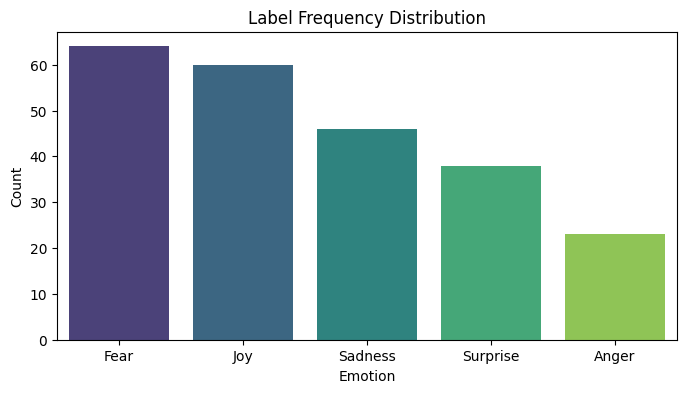

In [54]:
label_counts = {}
for label in labels:
    # Assuming binary values, summing gives the count of positives for each emotion.
    count = df_translated[label].sum()
    label_counts[label] = count
    print(f"{label}: {count}")

# Create a DataFrame to visualize label frequencies
label_freq_df = pd.DataFrame.from_dict(label_counts, orient='index', columns=['Count'])
label_freq_df.sort_values(by='Count', ascending=False, inplace=True)

plt.figure(figsize=(8, 4))
sns.barplot(x=label_freq_df.index, y='Count', data=label_freq_df, palette="viridis")
plt.title("Label Frequency Distribution")
plt.ylabel("Count")
plt.xlabel("Emotion")
plt.show()

In [55]:
df_translated['label_sum'] = df_translated[labels].sum(axis=1)
average_labels = df_translated['label_sum'].mean()
print(f"\nAverage number of labels per sample (Label Cardinality): {average_labels:.2f}")


Average number of labels per sample (Label Cardinality): 1.20


count    193.000000
mean      16.937824
std       13.146858
min        3.000000
25%        7.000000
50%       14.000000
75%       21.000000
max       92.000000
Name: text_length, dtype: float64


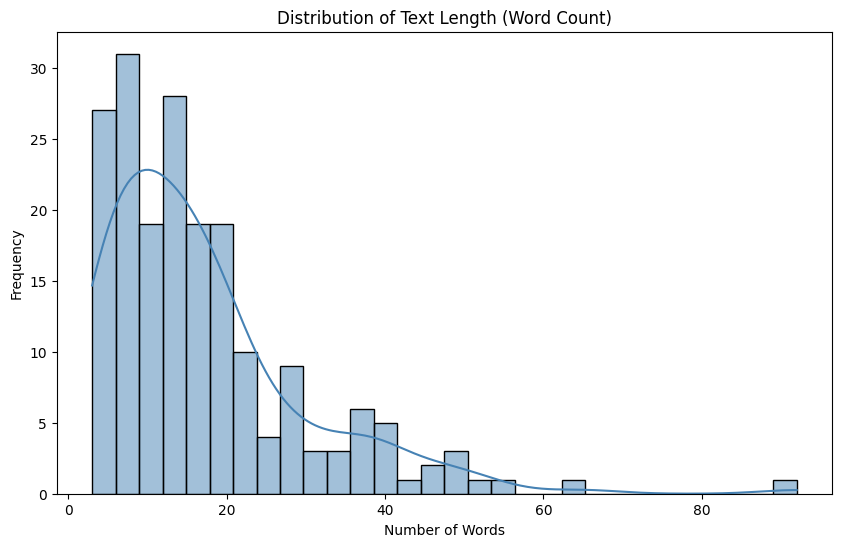


Vocabulary size (unique words): 1431
Top 10 most common words:
the: 144
i: 103
my: 91
and: 85
to: 75
a: 65
of: 50
in: 48
is: 37
you: 35

Number of extremely short texts (< 3 words): 0
Number of extremely long texts (> 95th percentile): 10


In [62]:
df_translated['text_length'] = df_translated['text'].apply(lambda x: len(x.split()))
print(df_translated['text_length'].describe())

plt.figure(figsize=(10, 6))
sns.histplot(df_translated['text_length'], bins=30, kde=True, color="steelblue")
plt.title("Distribution of Text Length (Word Count)")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.show()

all_words = df_translated['text'].str.lower().str.split().explode()
vocab = all_words.unique()
vocab_size = len(vocab)
print(f"\nVocabulary size (unique words): {vocab_size}")

word_counts = Counter(all_words.dropna())
most_common = word_counts.most_common(10)
print("Top 10 most common words:")
for word, count in most_common:
    print(f"{word}: {count}")

extreme_short = df_translated[df_translated['text_length'] < 3]
extreme_long = df_translated[df_translated['text_length'] > df_translated['text_length'].quantile(0.95)]

print(f"\nNumber of extremely short texts (< 3 words): {len(extreme_short)}")
print(f"Number of extremely long texts (> 95th percentile): {len(extreme_long)}")

In [46]:
train_data, valid_data = train_test_split(df_translated, test_size=0.25, random_state=42)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [49]:
train_dataset = EmotionDataset(
    train_data,
    tokenizer
)
valid_dataset = EmotionDataset(
    valid_data,
    tokenizer
)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=16)

# Define model and training components
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
print(f"Using device: {device}")
model = BertWithTransMIL().to(device)


# Compute pos_weight for BCEWithLogitsLoss 
values = train_data[labels].values.tolist()
labels_tensor = torch.tensor(values, dtype=torch.float)
num_positives = labels_tensor.sum(dim=0)
num_negatives = labels_tensor.shape[0] - num_positives
pos_weight = num_negatives / num_positives
pos_weight_tensor = torch.tensor(pos_weight, dtype=torch.float).to(device)

# Define the loss function
loss_func = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight_tensor)

#loss_func = CorrelationAwareLoss(pos_weight=class_weights, correlation_matrix=correlation_matrix)
# loss_func = nn.BCEWithLogitsLoss()


Using device: cpu


C:\Users\79217\AppData\Local\Temp\ipykernel_19164\1755432839.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos_weight_tensor = torch.tensor(pos_weight, dtype=torch.float).to(device)


In [50]:
# Add timestamp to the directory name
timestamp = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
name = "MIL_with_weights"
output_path = Path(f'model_{name}_{timestamp}')
output_path.mkdir(exist_ok=True, parents=True)

# FastAI DataLoaders
dls = DataLoaders(train_loader, valid_loader, device=device)

# Define Learner
learn = Learner(
    dls,
    model,
    loss_func=loss_func,
    opt_func=partial(OptimWrapper, opt=torch.optim.AdamW),
    metrics=[RocAuc()],
    path=output_path
)

# Callbacks
cbs = [
    SaveModelCallback(monitor='valid_loss', fname='best_valid'),
    EarlyStoppingCallback(monitor='valid_loss', patience=9),
    CSVLogger()
]

In [ ]:
learn.fit_one_cycle(n_epoch=5, reset_opt=True, lr_max=1e-4, wd=1e-2, cbs=cbs)

epoch,train_loss,valid_loss,roc_auc_score,time
0,1.121456,1.025993,0.636031,05:21


Better model found at epoch 0 with valid_loss value: 1.0259929895401.


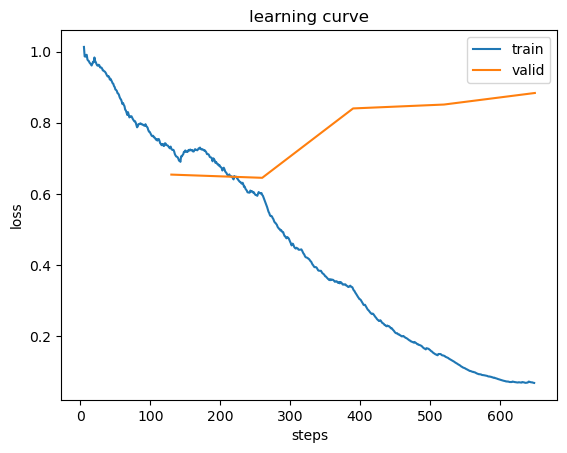

In [5]:
learn.recorder.plot_loss()
plt.show()

In [52]:
def predict_and_save_with_texts(learner, texts, output_csv):
    if learner.dls.valid is None:
        raise ValueError("The Learner does not have a validation DataLoader.")
    
    preds, targs = learner.get_preds(dl=learner.dls.valid)

    preds_binary = (preds > 0).int()

    results_df = pd.DataFrame({
        "Text": texts,
        "True Labels": [list(map(int, x)) for x in targs],
        "Predicted Labels": [list(map(int, x)) for x in preds_binary]
    })

    results_df.to_csv(output_csv, index=False)
    print(f"Predictions saved to {output_csv}")


results_path = Path(f"results_{name}_{timestamp}")
results_path.mkdir(exist_ok=True, parents=True)
output_csv = f"{results_path}/validation_predictions.csv"

# Load best model
best_model_path = output_path / 'models' / 'best_valid.pth'
learn.load(best_model_path.stem)

# Get validation texts and make predictions
validation_texts = valid_data["text"].tolist()
predict_and_save_with_texts(learn, validation_texts, output_csv=output_csv)


c:\Users\79217\Documents\TUD\3 semester\LLM\SemEval\.venv\Lib\site-packages\fastai\learner.py:61: UserWarning: Saved file doesn't contain an optimizer state.
  elif with_opt: warn("Saved file doesn't contain an optimizer state.")


Predictions saved to results_MIL_with_weights_2025-02-01_12-46-14/validation_predictions.csv


In [ ]:
model = BertEmotionClassifier(5)
model_path =  os.path.join(base_dir, output_path, "models", "best_valid.pth")
model.load_state_dict(torch.load(model_path))
model.eval()  # Set the model to evaluation mode


BertEmotionClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, ele

In [16]:
dev_data_path =  os.path.join(base_dir, "public_data", "dev", "track_a", "eng_a.csv")
data_eng = pd.read_csv(dev_data_path)


In [17]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Function to preprocess and predict
def predict_classes(model, texts, tokenizer, max_len=128):
    """
    Predict classes for a list of texts using the provided model and tokenizer.

    Args:
        model: The loaded PyTorch model.
        texts: A list of input sentences.
        tokenizer: The tokenizer for preprocessing the input.
        max_len: Maximum sequence length for tokenization.

    Returns:
        predictions: Predicted labels for the input texts.
    """
    predictions = []

    with torch.no_grad():
        for text in texts:
            # Tokenize and prepare input
            encoded = tokenizer(
                text,
                padding="max_length",
                truncation=True,
                max_length=max_len,
                return_tensors="pt"
            )
            input_ids = encoded["input_ids"]
            attention_mask = encoded["attention_mask"]

            # Make predictions
            logits = model(input_ids, attention_mask)
            probs = torch.sigmoid(logits)  # Multi-label classification
            predicted_labels = (probs > 0.5).int().tolist()[0]  # Binary predictions

            predictions.append(predicted_labels)
    
    return predictions

# Apply the model to the dataset
texts = data_eng["text"].fillna("").tolist()  # Handle missing texts
predictions = predict_classes(model, texts, tokenizer)

# Add predictions to the DataFrame
emotion_labels = ["Anger", "Fear", "Joy", "Sadness", "Surprise"]
prediction_df = pd.DataFrame(predictions, columns=emotion_labels)
data_eng[emotion_labels] = prediction_df

# Save the updated DataFrame to a new file
output_path =  os.path.join(base_dir, "public_data", "dev", "track_a", "eng_with_predictions_CAL.csv")
data_eng.to_csv(output_path, index=False)

print(f"Predictions saved to {output_path}")

TypeError: BertEmotionClassifier.forward() takes 2 positional arguments but 3 were given

In [ ]:
# Correct the device for inference
device = torch.device("mps")

# Load tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Load the trained model and set it to evaluation mode
model = BertEmotionClassifier(5)
model.load_state_dict(torch.load("/Users/vav/Documents/TUD/Semester 3/LLM/Project/MIL_BCE_weights/models/best_valid.pth", map_location=device))
model.to(device)
model.eval()

# Define the function for preprocessing and predicting
def predict_classes(model, texts, tokenizer, max_len=128):
    """
    Predict classes for a list of texts using the provided model and tokenizer.
    """
    predictions = []

    with torch.no_grad():
        for text in texts:
            # Tokenize and prepare input
            encoded = tokenizer(
                text,
                padding="max_length",
                truncation=True,
                max_length=max_len,
                return_tensors="pt"
            )
            input_ids = encoded["input_ids"].to(device)
            attention_mask = encoded["attention_mask"].to(device)

            # Make predictions
            logits = model((input_ids, attention_mask))
            probs = torch.sigmoid(logits)  # Multi-label classification
            predicted_labels = (probs > 0.5).int().tolist()[0]

            predictions.append(predicted_labels)
    
    return predictions

# Load and preprocess the new dataset
dev_data_path = "/Users/vav/Documents/TUD/Semester 3/LLM/Project/public_data_dev/track_a/dev/eng.csv"
data_eng = pd.read_csv(dev_data_path)
texts = data_eng["text"].fillna("").tolist()  # Handle missing texts

# Make predictions
predictions = predict_classes(model, texts, tokenizer)

# Add predictions to the DataFrame
emotion_labels = ["anger", "fear", "joy", "sadness", "surprise"]
prediction_df = pd.DataFrame(predictions, columns=emotion_labels)
data_eng[emotion_labels] = prediction_df

# Save the updated DataFrame to a new file
output_path = "/Users/vav/Documents/TUD/Semester 3/LLM/Project/public_data_dev/track_a/dev/eng_with_predictions.csv"
data_eng.to_csv(output_path, index=False)

print(f"Predictions saved to {output_path}")


Predictions saved to /Users/vav/Documents/TUD/Semester 3/LLM/Project/public_data_dev/track_a/dev/eng_with_predictions.csv
